In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
from cuml import ForestInference
import sys
from tqdm import tqdm
import os
import random
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

In [2]:
config = f"""
execution:
    exp_id: exp_004
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs

feature:
    agg_freq: 120 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

## 特徴生成

In [3]:
def generate_features(train: pd.DataFrame):
    features = Features()

    # 時刻
    timestamp = pd.to_datetime(train["timestamp"].values[0])
    total_seconds = (timestamp - timestamp.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    train["total_seconds"] = (total_seconds + train.index * 5) % (24 * 60 * 60) # [sec]
    features.add_num_feature("total_seconds")    
    
    # センサのラグ特徴量
    dts = [-100, -50, -30, -10, -5, -3, -2, -1, 1, 2, 3, 5, 10, 30, 50, 100]
    columns = ["anglez", "enmo"]
    for dt in dts:            
        # diff
        f_names = [f"{c}_diff_{dt}" for c in columns]
        train[f_names] = train[columns].diff(dt)
        features.add_num_features(f_names)

        # rolling
        if dt > 0:
            f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).mean()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_std_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).std()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_max_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).max()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_min_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).min()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_median_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).median()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
            train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
            features.add_num_features(f_names)

    # 一定stepで集約
    series_id = train["series_id"].values[0]
    agg_freq = CFG["feature"]["agg_freq"]
    columns = features.all_features() + ["target", "step"]
    train = train[columns].groupby(np.arange(len(train)) // agg_freq).mean()
    train["series_id"] = series_id
    train["target"] = train["target"].round().astype(int)

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

def read_and_generate_features(file):
    train = pd.read_csv(file)
    train, features = generate_features(train)
    return train, features

In [4]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.csv")

if CFG["execution"]["multiprocessing"]:
    with Pool(30) as pool:
        results = list(tqdm(pool.imap(read_and_generate_features, files), total=len(files)))
    dfs, features = zip(*results)
    train = pd.concat(dfs)
    features = features[0]
else:
    dfs = []
    for file in tqdm(files):
        train = pd.read_csv(file)
        train, features = generate_features(train)
        dfs.append(train)
    train = pd.concat(dfs)
    features = features[0]

100%|██████████| 277/277 [08:22<00:00,  1.81s/it]


## 学習

In [5]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train = train.merge(cv_split, on=["series_id"], how="left")
train.head(5)

,anglez_diff_-1,anglez_diff_-10,anglez_diff_-100,anglez_diff_-2,anglez_diff_-3,anglez_diff_-30,anglez_diff_-5,anglez_diff_-50,anglez_diff_1,anglez_diff_10,...,enmo_rolling_std_2,enmo_rolling_std_3,enmo_rolling_std_30,enmo_rolling_std_5,enmo_rolling_std_50,total_seconds,target,step,series_id,fold
0,-0.000279,-0.002193,-0.010558,-0.000551,-0.000798,-0.003629,-0.000973,-0.007242,0.000282,0.001140,...,0.000174,0.000213,0.000762,0.000277,0.001087,40797.5,1,59.5,af91d9a50547,2
1,0.000000,0.003592,4.272784,0.000363,0.001057,1.534871,0.001642,2.398812,0.000000,-0.002788,...,0.000000,0.000000,0.000000,0.000000,0.000557,41397.5,1,179.5,af91d9a50547,2
2,1.054623,11.702290,131.127411,2.180833,3.228815,38.599536,5.588879,66.663457,-1.268946,-4.698234,...,0.001866,0.002305,0.007523,0.002881,0.009895,41997.5,1,299.5,af91d9a50547,2
3,-0.138284,-4.447657,-69.739179,-0.260888,-0.005988,-28.818603,0.052810,-48.358210,-0.067602,-4.248959,...,0.021078,0.024982,0.044443,0.029248,0.048959,42597.5,1,419.5,af91d9a50547,2
4,0.140703,3.866942,23.372769,0.213554,0.081092,16.278662,-0.113383,25.251739,0.085398,-2.901016,...,0.032636,0.039981,0.072942,0.047381,0.084753,43197.5,1,539.5,af91d9a50547,2


In [6]:
if CFG['execution']['submit']:
    # 推論
    models = [
        ForestInference.load(
            os.path.join(CFG["model_dir"], f'xgb_fold{i}.model'),
            output_class=True,
            model_type='xgboost'
        ) for i in range(CFG.n_fold)]
    pred = inference_xgb(models, train[features])
else:
    # 学習
    trn_oof, models = fit_xgb(train[features.all_features()], train["target"], train["fold"].astype(
        int), params=CFG["xgboost"], es_rounds=50)
    train["oof"] = trn_oof

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-logloss:0.62583
[50]	eval-logloss:0.17725
[100]	eval-logloss:0.16716
[150]	eval-logloss:0.16500
[200]	eval-logloss:0.16437
[250]	eval-logloss:0.16373
[300]	eval-logloss:0.16378
[329]	eval-logloss:0.16400


 20%|██        | 1/5 [01:45<07:02, 105.64s/it]

== fold 1 ==
[0]	eval-logloss:0.62512
[50]	eval-logloss:0.17642
[100]	eval-logloss:0.16226
[150]	eval-logloss:0.15822
[200]	eval-logloss:0.15646
[250]	eval-logloss:0.15545
[300]	eval-logloss:0.15492
[350]	eval-logloss:0.15430
[400]	eval-logloss:0.15410
[450]	eval-logloss:0.15376
[500]	eval-logloss:0.15356
[550]	eval-logloss:0.15343
[594]	eval-logloss:0.15358


 40%|████      | 2/5 [04:39<07:17, 145.93s/it]

== fold 2 ==
[0]	eval-logloss:0.62568
[50]	eval-logloss:0.15964
[100]	eval-logloss:0.14470
[150]	eval-logloss:0.14035
[200]	eval-logloss:0.13821
[250]	eval-logloss:0.13667
[300]	eval-logloss:0.13571
[350]	eval-logloss:0.13519
[400]	eval-logloss:0.13476
[450]	eval-logloss:0.13423
[500]	eval-logloss:0.13406
[550]	eval-logloss:0.13391
[599]	eval-logloss:0.13396


 60%|██████    | 3/5 [07:36<05:19, 159.83s/it]

== fold 3 ==
[0]	eval-logloss:0.62473
[50]	eval-logloss:0.17085
[100]	eval-logloss:0.16101
[150]	eval-logloss:0.15835
[200]	eval-logloss:0.15677
[250]	eval-logloss:0.15591
[300]	eval-logloss:0.15511
[350]	eval-logloss:0.15470
[400]	eval-logloss:0.15426
[450]	eval-logloss:0.15418
[500]	eval-logloss:0.15416
[550]	eval-logloss:0.15409
[600]	eval-logloss:0.15393
[650]	eval-logloss:0.15378
[700]	eval-logloss:0.15368
[750]	eval-logloss:0.15353
[800]	eval-logloss:0.15357
[813]	eval-logloss:0.15360


 80%|████████  | 4/5 [11:30<03:09, 189.10s/it]

== fold 4 ==
[0]	eval-logloss:0.62582
[50]	eval-logloss:0.16807
[100]	eval-logloss:0.15400
[150]	eval-logloss:0.15019
[200]	eval-logloss:0.14805
[250]	eval-logloss:0.14669
[300]	eval-logloss:0.14583
[350]	eval-logloss:0.14517
[400]	eval-logloss:0.14467
[450]	eval-logloss:0.14434
[500]	eval-logloss:0.14408
[550]	eval-logloss:0.14375
[600]	eval-logloss:0.14366
[650]	eval-logloss:0.14337
[700]	eval-logloss:0.14316
[750]	eval-logloss:0.14304
[800]	eval-logloss:0.14290
[850]	eval-logloss:0.14271
[900]	eval-logloss:0.14271
[950]	eval-logloss:0.14262
[1000]	eval-logloss:0.14248
[1050]	eval-logloss:0.14245
[1100]	eval-logloss:0.14248
[1118]	eval-logloss:0.14250


100%|██████████| 5/5 [17:03<00:00, 204.78s/it]


In [9]:
train = train.drop(columns=features.all_features())
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)
train

,target,step,series_id,fold,oof
0,1,59.5,038441c925bb,2,0.986094
1,1,179.5,038441c925bb,2,0.986338
2,1,299.5,038441c925bb,2,0.990575
3,1,419.5,038441c925bb,2,0.994496
4,1,539.5,038441c925bb,2,0.998662
...,...,...,...,...,...
1066280,1,591899.5,fe90110788d2,2,0.086967
1066281,1,592019.5,fe90110788d2,2,0.103015
1066282,1,592139.5,fe90110788d2,2,0.103015
1066283,1,592259.5,fe90110788d2,2,0.065438


## 予測値の作成

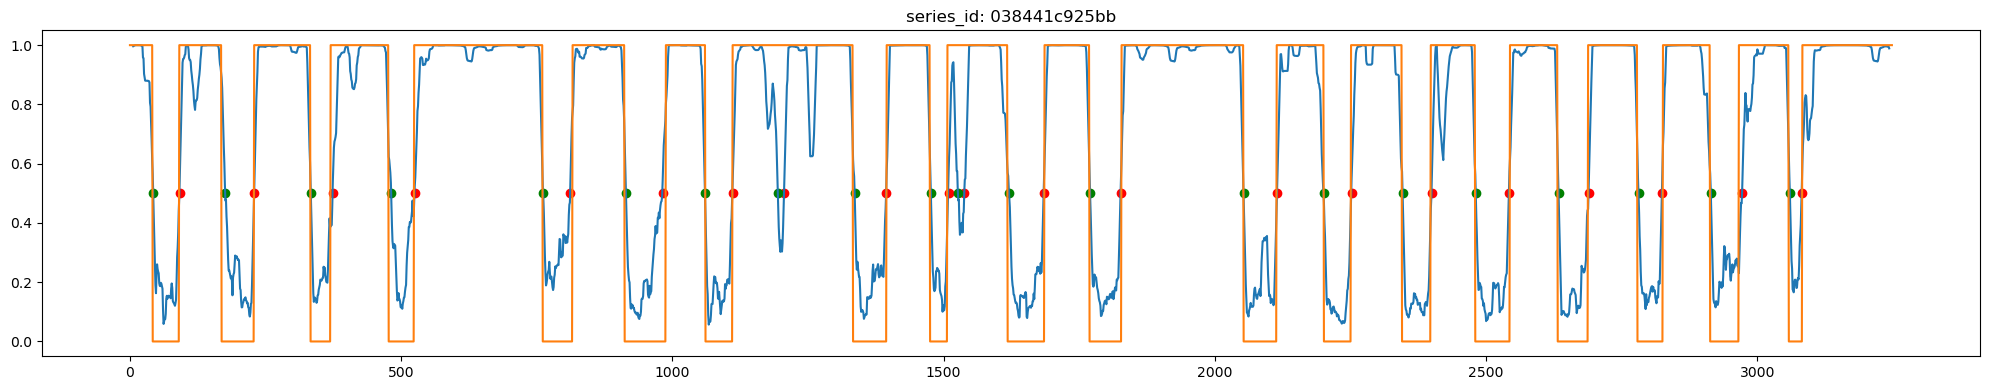

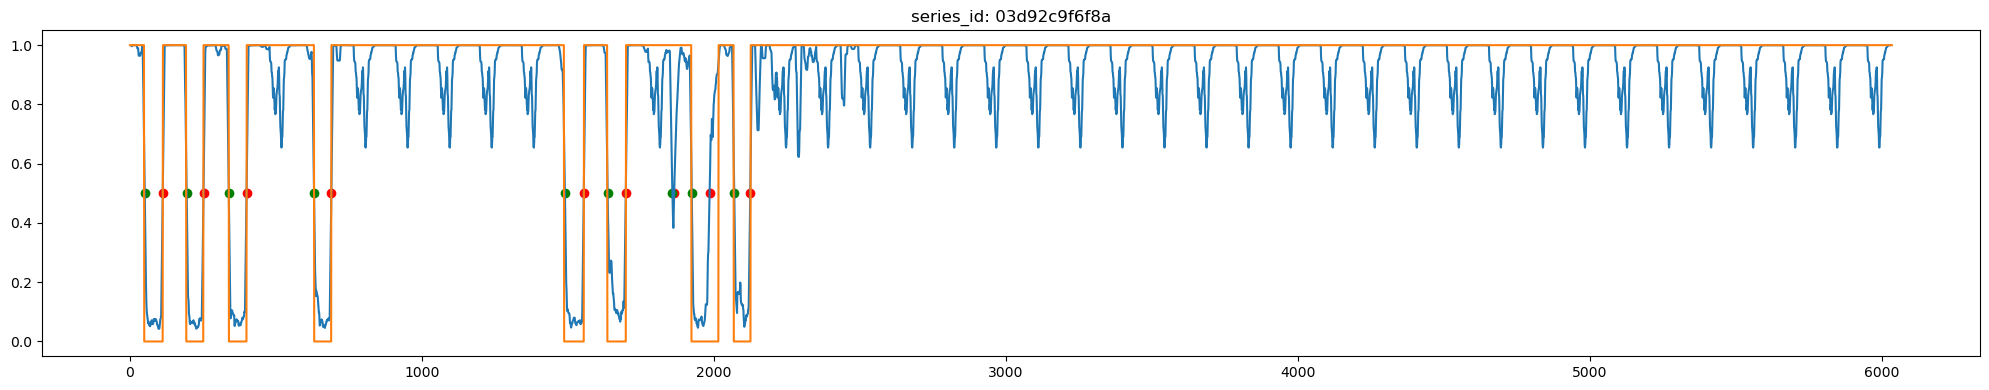

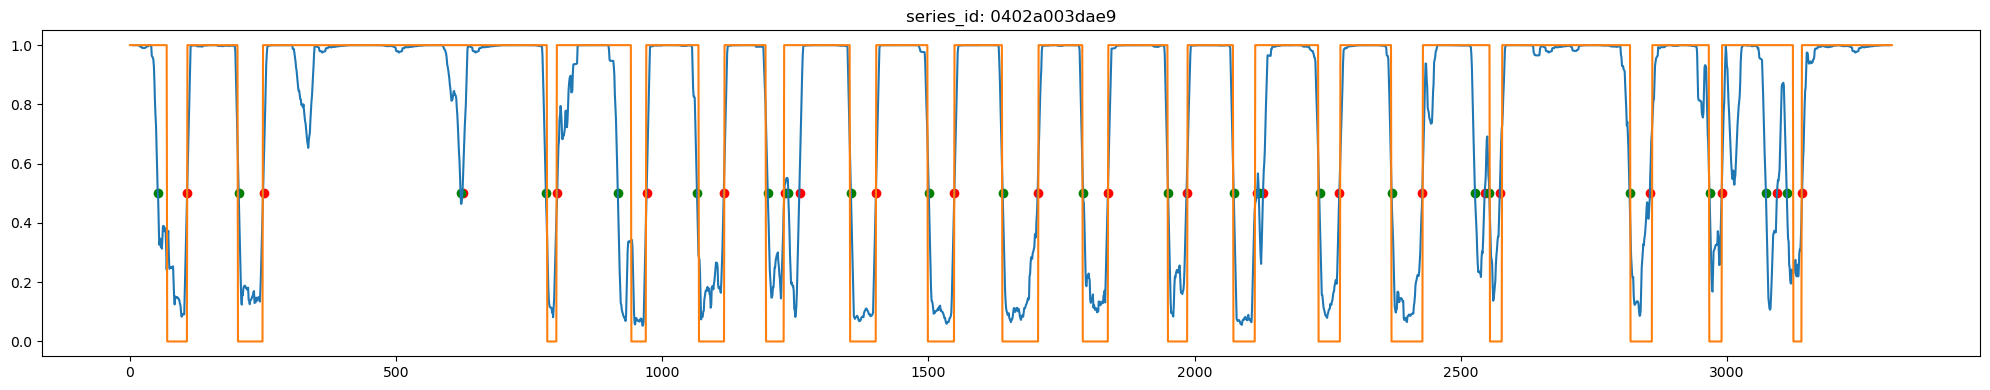

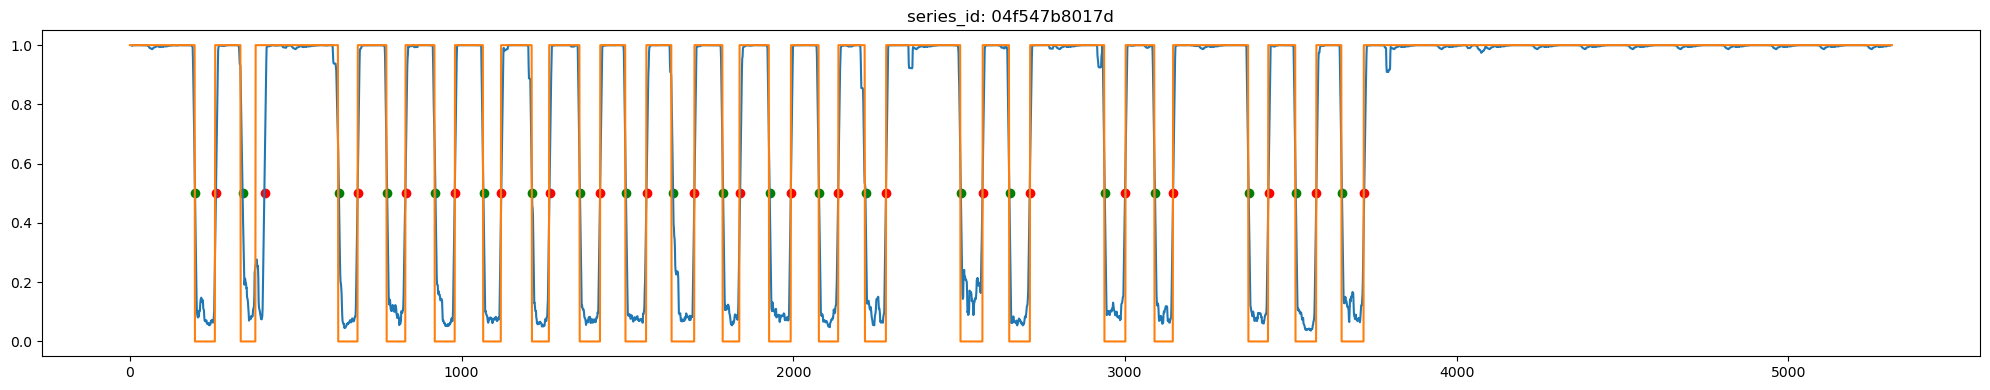

,series_id,step,event,score
0,038441c925bb,11039,wakeup,1
1,038441c925bb,27479,wakeup,1
2,038441c925bb,44879,wakeup,1
3,038441c925bb,62999,wakeup,1
4,038441c925bb,97439,wakeup,1


In [29]:
dfs = []
for series_id, df in train.groupby("series_id"):
    df = df.reset_index(drop=True)
    oof = df["oof"].rolling(12, center=True).mean()
    wakeup_index = np.array([i for i in range(1, len(oof)) if oof[i-1] < 0.5 and oof[i] >= 0.5])
    onset_index = np.array([i for i in range(1, len(oof)) if oof[i-1] > 0.5 and oof[i] <= 0.5])

    sub = pd.concat([
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[wakeup_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "wakeup",
            "score": 1,
        }),
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[onset_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "onset",
            "score": 1,
        }),
    ])
    sub["step"] = sub["step"].astype(int)
    dfs.append(sub)

    if len(dfs) < 5:
        plt.subplots(figsize=(20, 4))
        plt.plot(oof)
        plt.plot(df["target"])
        plt.scatter(wakeup_index, [0.5 for _ in wakeup_index], c="red")
        plt.scatter(onset_index, [0.5 for _ in onset_index], c="green")
        plt.title(f"series_id: {series_id}")
        plt.tight_layout()
        plt.show()

sub = pd.concat(dfs).reset_index(drop=True)
sub.head()

score: 0.2311


event   tolerance
onset   12           0.000440
        36           0.004662
        60           0.015295
        90           0.032661
        120          0.077329
        150          0.120092
        180          0.204467
        240          0.330759
        300          0.431908
        360          0.503078
wakeup  12           0.003755
        36           0.043886
        60           0.092861
        90           0.186220
        120          0.251858
        150          0.337604
        180          0.386669
        240          0.472451
        300          0.540996
        360          0.584182
dtype: float64

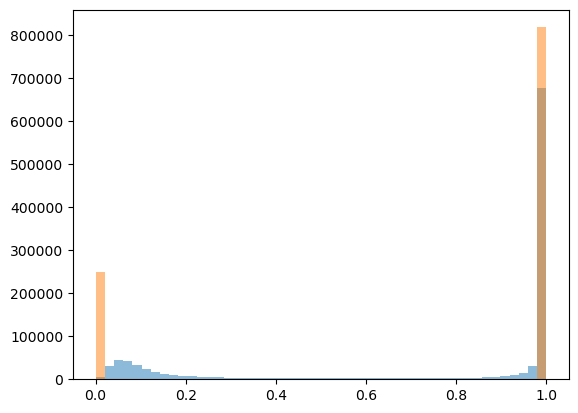

In [30]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()

In [79]:
# 次の候補の大きさ
next_cand_size = 0
count = 0
for series_id, train_df in train.groupby("series_id"):
    train_df = train_df[(train_df["oof"] >= 0.1) & (train_df["oof"] <= 0.9)]
    sub_df = sub[(sub["series_id"] == series_id)]
    label_df = labels[labels["series_id"] == series_id]
    pred_steps = train_df["step"].values
    sub_steps = sub_df["step"].values
    label_steps = label_df["step"].values

    next_cand = np.zeros(int(train_df["step"].max()) + CFG["feature"]["agg_freq"])
    for sub_step in sub_steps:
        next_cand[int(sub_step - CFG["feature"]["agg_freq"] * 5): int(sub_step + CFG["feature"]["agg_freq"] * 5)] = 1
    for pred_step in pred_steps:
        next_cand[int(pred_step - CFG["feature"]["agg_freq"] * 5): int(pred_step + CFG["feature"]["agg_freq"] * 5)] = 1
    next_cand_size += np.sum(next_cand)

    for label_step in label_steps:
        if label_step < next_cand.shape[0]:
            count += next_cand[int(label_step)]
recall = count / len(labels)
print(f"recall: {recall:.4f}")
print(f"next_cand_size: {next_cand_size}")

recall: 0.9908
next_cand_size: 52372770.0
